## Q7: Noisy signal
A convolution is defined as:  

\begin{equation}  
  (f \star g)(t) \equiv \int_{-\infty}^{\infty} f(\tau) g(t - \tau) d\tau \tag{1}  
\end{equation}  

It is easy to compute this with FFTs, via the _convolution theorem_,  

\begin{equation}  
  \mathcal{F}\{f \star g\} = \mathcal{F}\{f\} \, \mathcal{F}\{g\} \tag{2}  
\end{equation}  

That is: the Fourier transform of the convolution of $f$ and $g$ is simply the product of the individual transforms of $f$ and $g$. This allows us to compute the convolution via multiplication in Fourier space and then take the inverse transform, $\mathcal{F}^{-1}\{\}$, to recover the convolution in real space:

\begin{equation}  
  f \star g = \mathcal{F}^{-1}\{ \mathcal{F}\{f\} \, \mathcal{F}\{g\}\} \tag{3}  
\end{equation}  

A common use of a convolution is to smooth noisy data, for example by convolving noisy data with a Gaussian. We'll do that here.

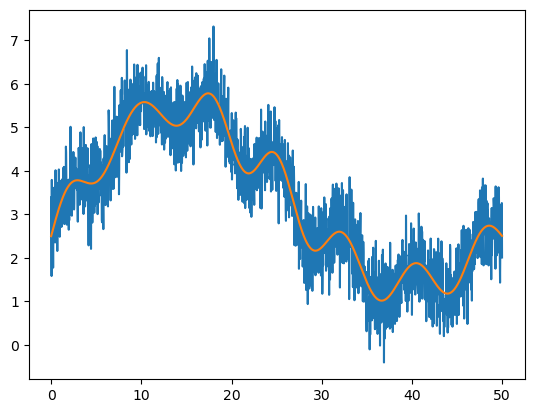

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def fdata(x, L):
    A = L/10.0
    return 2*np.sin(2*np.pi*x/L) + x*(L-x)**2/L**3 * np.cos(x) + \
           5*x*(L-x)/L**2 + A/2 + 0.1*A*np.sin(13*np.pi*x/L)

N = 2048
L = 50.0
x = np.linspace(0, L, N, endpoint=False)
orig = fdata(x, L)
noisy = orig + 0.5*np.random.randn(N)

plt.plot(x, noisy)
plt.plot(x, orig)

SciPy provides a convolution function `scipy.signal.convolve()` that can do the convolution for us directly.  To smooth the data, we want to use a Gaussian, which can be produced by `scipy.signal.windows.gaussian()`.

Convolve the noisy data with a Gaussian and plot the result together with the original data `orig`.  You'll need to play with the width of the Gaussian to get a nice smoothing.  You also will need to normalize the Gaussian so that it sums to 1, otherwise, your convolved data will be shifted verfically from the original function.

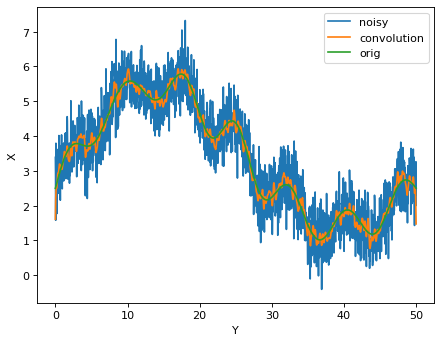

In [3]:
import scipy.signal as signal

#MAIN
Npoints = 25
std = 3

filter = signal.windows.gaussian(Npoints, std)
convolution = signal.convolve(noisy, filter, mode='same', method='auto') #use "same" otherwise with "full" it appends N-1 elements at the end 

convolution /= sum(filter) #normalize

fig = plt.figure(dpi = 80)
ax = fig.add_subplot(111)
ax.plot(x, noisy, label = "noisy")
ax.plot(x, convolution, label = "convolution")
ax.plot(x, orig, label = "orig")
ax.set_xlabel("Y")
ax.set_ylabel("X")
ax.legend()

## Q8: FFT of the chaotic pendulum

In Q6 we looked at ODEs and the chaotic pendulum, and were interested in writing a method to integrate the pendulum in time.

Here we want to examine its behavior in frequency space.  The code below will integrate the chaotic pendulum, while requesting that the solution be stored at points spaced with a fixed dt, which makes it suitable for taking the FFT.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy.integrate import solve_ivp

def rhs(t, Y, q, omega_d, b):
    """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
    f = np.zeros_like(Y)
        
    f[0] = Y[1]
    f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

    return f

def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

def int_pendulum(theta0, q, omega_d, b, tend, dt):
    """ integrate the pendulum and return solution with dt"""

    # points in time where we'll request the solution
    tpoints = np.arange(0.0, tend, dt)
    
    r = solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=b),
                  [0.0, tend], [theta0, 0.0],
                  method='RK45', t_eval=tpoints)

    return r.t, r.y

The call below will give an undamped pendulum.  For a small amplitude, since we have $L = g$ in our pendulum, the period is simply $T = 2\pi$, and the frequency is $\nu_k = 1/(2\pi)$.  We plot things in terms of angular frequency, $\omega_k = 2\pi \nu_k$, so all the power will be at $\omega_k = 1$.

In [5]:
#t, y = int_pendulum(np.radians(10), 0.0, 0.6666, 0.0, 200.0, 0.1) #suggested start
t, y = int_pendulum(np.radians(54), 0.01, 0.1, 0.01, 500.0, 0.1) #theta0, q, omega_d, b, tend, dt

Your task is to complete the power spectrum routine below to calculate the FFT of theta and plot it.  Experiment with the damping and driving parameters to see the complexity of the pendulum in frequency space when it becomes chaotic.  For reference, here's a plot of the solution theta

Text(0, 0.5, '$\\theta$')

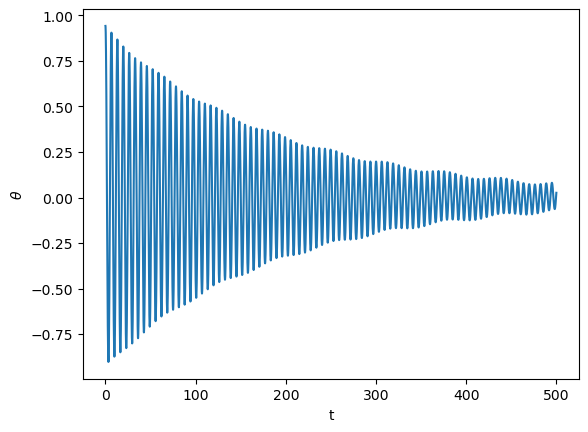

In [6]:
plt.plot(t, restrict_theta(y[0,:]))
plt.xlabel("t")
plt.ylabel(r"$\theta$")

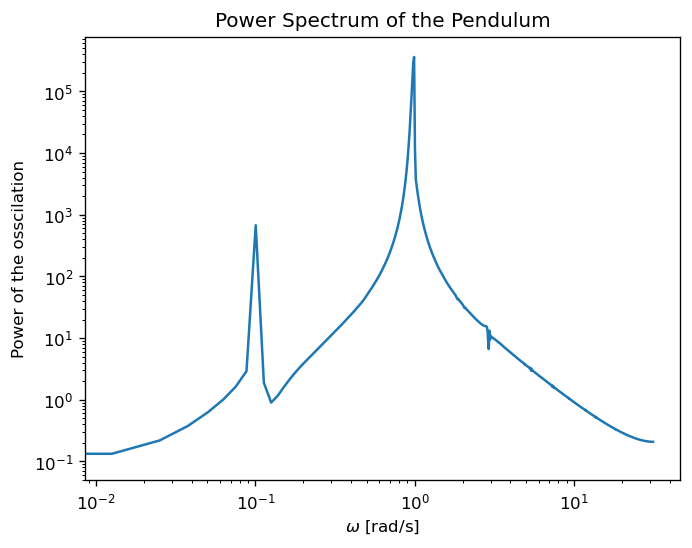

In [7]:
def power_spectrum(t, theta0):
    """Return (omega_k, P_k) where omega_k is the angular frequency array
       and P_k is the power spectrum of the restricted theta(t)."""

    theta = restrict_theta(theta0)

    dt = t[1] - t[0]
    N = len(theta)

    theta_fft = np.fft.fft(theta) 
    freqs = np.fft.fftfreq(N, dt)

    mask = freqs >= 0 #pinking only the freq > 0
    freqs = freqs[mask]
    theta_fft = theta_fft[mask]

    omega_k = 2.0 * np.pi * freqs

    P_k = np.abs(theta_fft)**2

    return omega_k, P_k

#MAIN
omega_k, P_k = power_spectrum(t, y[0,:])

fig = plt.figure(dpi = 120)
ax = fig.add_subplot(111)
ax.plot(omega_k, P_k)
ax.set_xlabel(r"$\omega$ [rad/s]")
ax.set_ylabel("Power of the osscilation")
ax.set_title("Power Spectrum of the Pendulum")
ax.set_xscale("log")
ax.set_yscale("log")
#ax.xlim(0, max(omega_k))
plt.show()